In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import math
import mne

In [3]:
if 'google.colab' in str(get_ipython()):
 os.chdir('/content/drive/MyDrive/BSc_Project/')

base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'datasets')
print(f'datasets directory: {dataset_dir}')

current directory: /content/drive/MyDrive/BSc_Project
datasets directory: /content/drive/MyDrive/BSc_Project/datasets


####**Utility plotting functions**

###**Pre-processing for Dataset A** <br>
This dataset consists of 45, 39 text files for each class (sch (1), norm (0)) respectively <br>

total length of the recording is **1 minute** (7680 samples / 128 Hz sample rate), 
dividing each recording into 5 second segments **(128 x 5 x 16 channels)**

In [4]:
def read_A_dataset(path, case_str):
  case_path = os.path.join(path, case_str)
  subjects_list = []
  for filename in os.listdir(case_path):
    with open(os.path.join(case_path, filename), 'r') as f:
      lines = f.readlines()
      subjects_list.append(lines)
  return subjects_list

# -----------------------------------------
def convert_to_numbers(sub_list):
  new_list = []
  for sub in sub_list:
    new_list.append([float(value) for value in sub])
  return new_list

# -----------------------------------------
def list_segments(lst, segments=16):
  arr = np.array(lst)
  return np.array_split(np.array(arr), segments)


# --------------------------------------------
def divide_to_channels(subjects_list, segments=16):
  return [list_segments(subject, segments) for subject in subjects_list]


# ----------------------------------------------
def log_data_shapes(sch, norm):
  return {
 'sch': (len(sch), len(sch[0]), sch[0][0].shape), 
 'norm': (len(norm), len(norm[0]), norm[0][0].shape)}

# --------------------------------------------------
def divide_time_segments(subject_list, time_window=5):
  n_segments = total_time // time_window
  return [np.split(channel, n_segments) for channel in subject_list]


# -----------------------------------------------
def create_spectrogram_data(subject_list):
  new_subject_list = []
  for subject in subject_list:
    specs = []
    segment_channels = divide_time_segments(subject)
    array_of_arrays = np.array([np.array(channel) for channel in segment_channels])
    for i in range(0, array_of_arrays.shape[1]):
      spec_data = np.squeeze(array_of_arrays[:, i, :].reshape((1, -1)))
      specs.append(spec_data)
    new_subject_list.append(specs)
  return new_subject_list


In [5]:
colors = ['black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow', 
          'black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow']

channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, subject_index=0, n_channels=16):
  fig = plt.figure(figsize=(20, 10), dpi=85)
  gs = gridspec.GridSpec(n_channels, 1) 

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    line, = ax.plot(data[subject_index][i], color=colors[i])
    ax.set_yticklabels([])
    ax.set_ylabel(f'{channels_16[i]}')
    plt.xlim([0, recording_len])

  # remove vertical gap between subplots
  plt.subplots_adjust(hspace=.0)
  plt.show()



def create_spectrogram(data, fs, impath= '', save=False):
  plt.specgram(data, Fs=fs, NFFT=1024)
  if save:
    plt.axis('off')
    plt.savefig(impath, dpi=300, pad_inches=0.0, transparent=True, bbox_inches='tight')
  else: plt.show()

In [6]:
recording_len = 7680
freq = 128
total_time = recording_len // freq
print(f'the recording is {total_time} seconds long and has total {recording_len} values')


norm_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'A'), 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'A'), 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')

the recording is 60 seconds long and has total 7680 values
no. subjects = norm: 37, sch:42


In [7]:
sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)

print('shapes: ', log_data_shapes(sch_channels, norm_channels))

norm_data = norm_channels
sch_data = sch_channels

norm_specgram_data = create_spectrogram_data(norm_data)
sch_specgram_data = create_spectrogram_data(sch_data)

print('\nspectrogram data shapes: ',log_data_shapes(sch_specgram_data, norm_specgram_data))

shapes:  {'sch': (42, 16, (7680,)), 'norm': (37, 16, (7680,))}

spectrogram data shapes:  {'sch': (42, 12, (10240,)), 'norm': (37, 12, (10240,))}



16 channel plot of one schizophernic subject


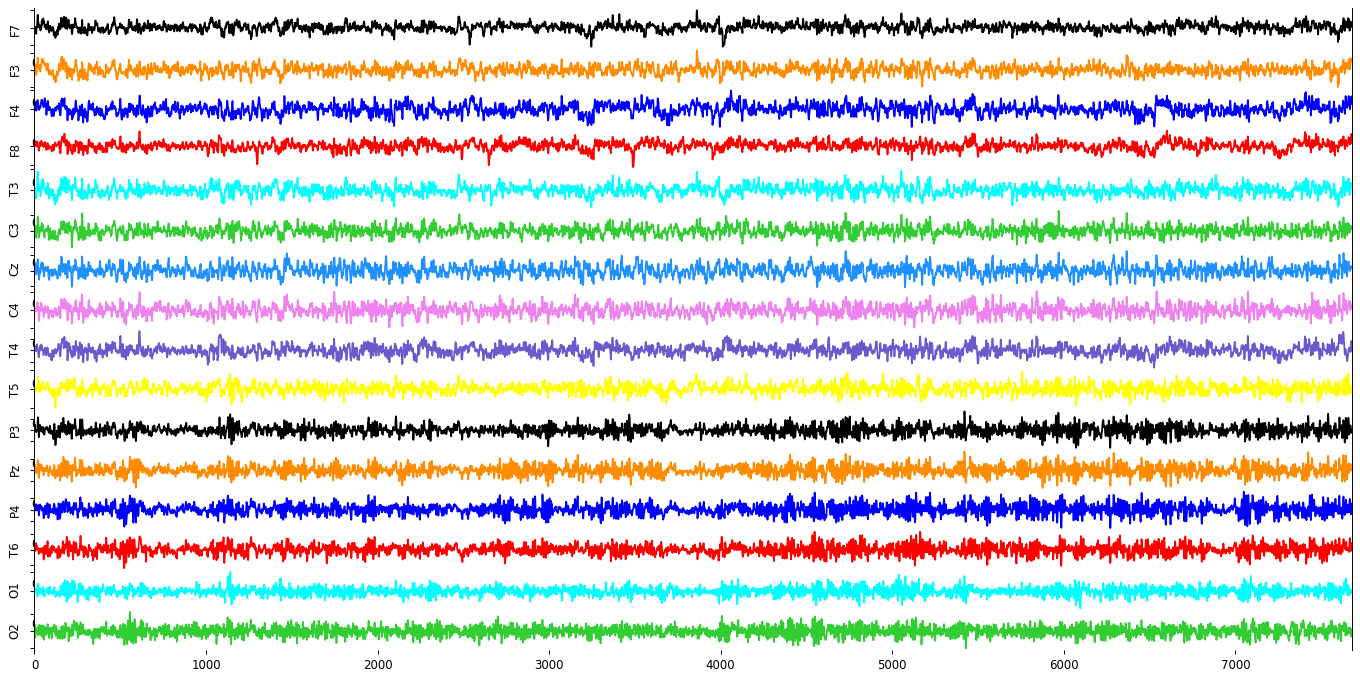

In [8]:
print("\n16 channel plot of one schizophernic subject")
plot_signals(sch_data, 1)


16 channel plot of one healthy subject 


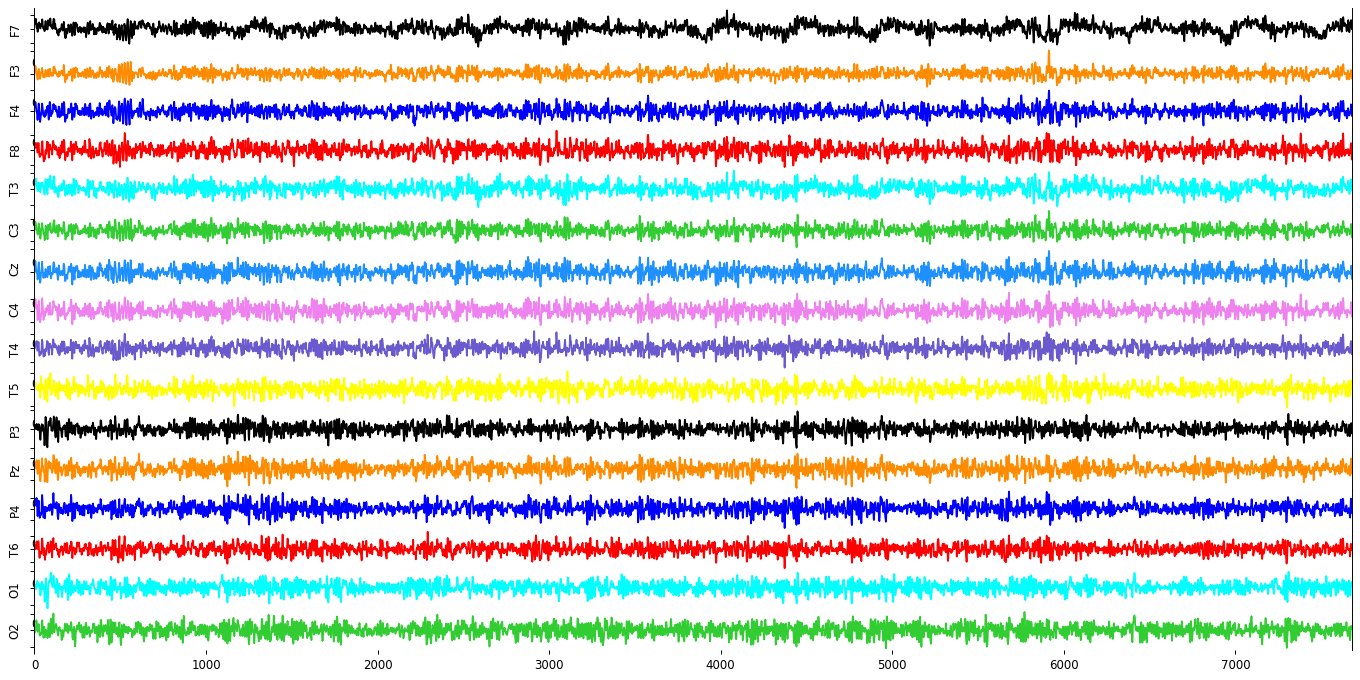

In [9]:
print("\n16 channel plot of one healthy subject ")
plot_signals(norm_data, 2)

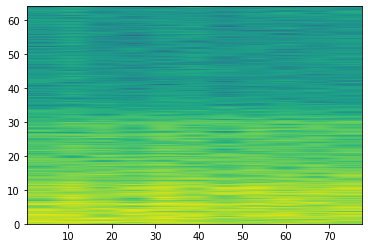

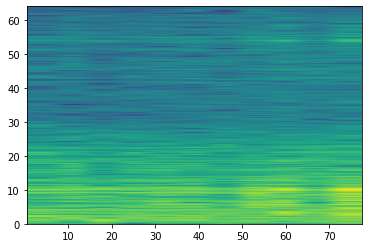

In [10]:
create_spectrogram(sch_specgram_data[0][0], fs=freq)
create_spectrogram(norm_specgram_data[0][0], fs=freq)

In [11]:
cwd = os.getcwd()

def generate_images_for_subject(path, subject_data, sub_index):
  for i, segment in enumerate(subject_data):
    filename = f'sub{sub_index}-seg{i}'
    print('generated: ', filename)
    create_spectrogram(segment, fs=freq, impath=os.path.join(path, filename), save=True)


def generate_images(data, path, start=0):
  if not os.path.exists(os.path.join(cwd, path)):
    os.mkdir(path)
  for i in range(start, len(data)):
    generate_images_for_subject(path, data[i], i)


In [12]:
images_path_a = os.path.join('out', 'A')

generated:  sub35-seg0
generated:  sub35-seg1
generated:  sub35-seg2
generated:  sub35-seg3
generated:  sub35-seg4
generated:  sub35-seg5
generated:  sub35-seg6
generated:  sub35-seg7
generated:  sub35-seg8
generated:  sub35-seg9
generated:  sub35-seg10
generated:  sub35-seg11
generated:  sub36-seg0
generated:  sub36-seg1
generated:  sub36-seg2
generated:  sub36-seg3
generated:  sub36-seg4
generated:  sub36-seg5
generated:  sub36-seg6
generated:  sub36-seg7
generated:  sub36-seg8
generated:  sub36-seg9
generated:  sub36-seg10
generated:  sub36-seg11
generated:  sub37-seg0
generated:  sub37-seg1
generated:  sub37-seg2
generated:  sub37-seg3
generated:  sub37-seg4
generated:  sub37-seg5
generated:  sub37-seg6
generated:  sub37-seg7
generated:  sub37-seg8
generated:  sub37-seg9
generated:  sub37-seg10
generated:  sub37-seg11
generated:  sub38-seg0
generated:  sub38-seg1
generated:  sub38-seg2
generated:  sub38-seg3
generated:  sub38-seg4
generated:  sub38-seg5
generated:  sub38-seg6
gener

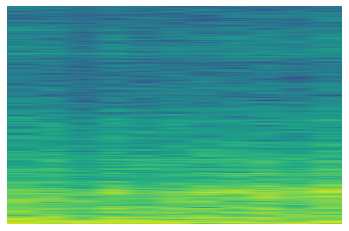

In [16]:
generate_images(sch_specgram_data, os.path.join(images_path_a, 'sch'), start=35)

generated:  sub28-seg0
generated:  sub28-seg1
generated:  sub28-seg2
generated:  sub28-seg3
generated:  sub28-seg4
generated:  sub28-seg5
generated:  sub28-seg6
generated:  sub28-seg7
generated:  sub28-seg8
generated:  sub28-seg9
generated:  sub28-seg10
generated:  sub28-seg11
generated:  sub29-seg0
generated:  sub29-seg1
generated:  sub29-seg2
generated:  sub29-seg3
generated:  sub29-seg4
generated:  sub29-seg5
generated:  sub29-seg6
generated:  sub29-seg7
generated:  sub29-seg8
generated:  sub29-seg9
generated:  sub29-seg10
generated:  sub29-seg11
generated:  sub30-seg0
generated:  sub30-seg1
generated:  sub30-seg2
generated:  sub30-seg3
generated:  sub30-seg4
generated:  sub30-seg5
generated:  sub30-seg6
generated:  sub30-seg7
generated:  sub30-seg8
generated:  sub30-seg9
generated:  sub30-seg10
generated:  sub30-seg11
generated:  sub31-seg0
generated:  sub31-seg1
generated:  sub31-seg2
generated:  sub31-seg3
generated:  sub31-seg4
generated:  sub31-seg5
generated:  sub31-seg6
gener

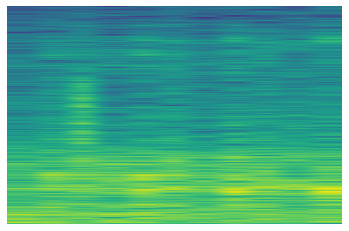

In [15]:
generate_images(norm_specgram_data, os.path.join(images_path_a, 'norm'), start=28)